In [1]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *

#define epsilon for test_hmmbatchsgd likelihood convergence
epsilon=10**(-2)

/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


[13.54846741  8.13267287]
Hamming Distance =  0.3576666666666667


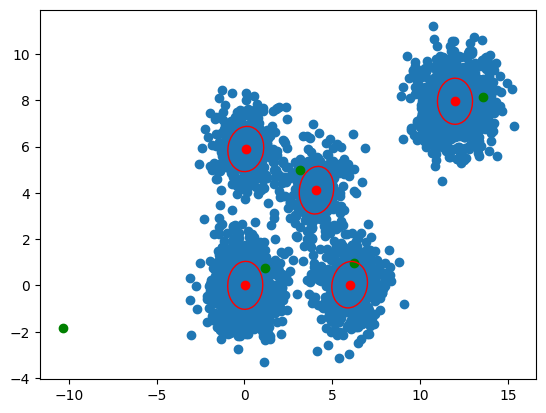

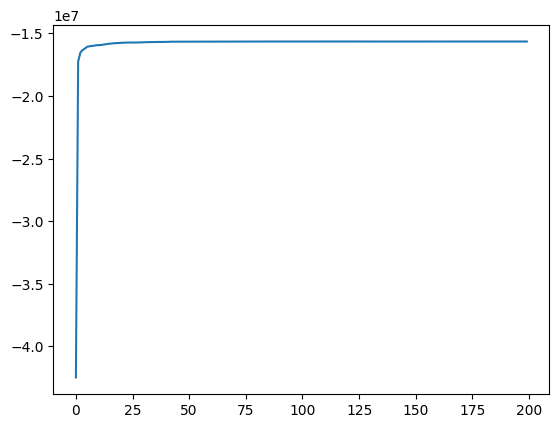

In [5]:
test_hmmbatchsgd(maxit=200, epsilon=epsilon, batch_size=256)

[3.47002712 2.98508716]
Hamming Distance =  0.317


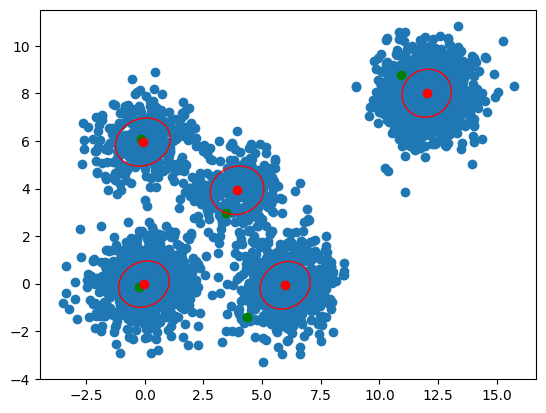

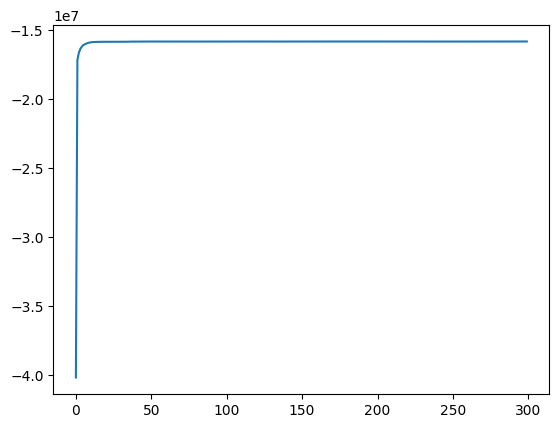

In [7]:
#batch 700 - 300 it
test_hmmbatchsgd(maxit=300, epsilon=epsilon, batch_size=700)

[10.08781362  8.79037302]
Hamming Distance =  0.37366666666666665


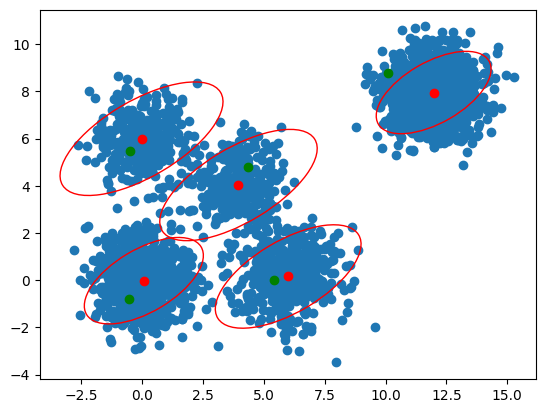

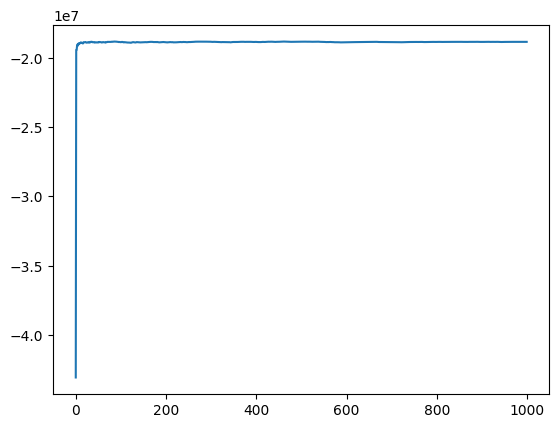

In [8]:
#batch 10 - 1000 it

test_hmmbatchsgd(maxit=1000, epsilon=epsilon, batch_size=10)

[10.90148735  7.52304667]
Hamming Distance =  0.388


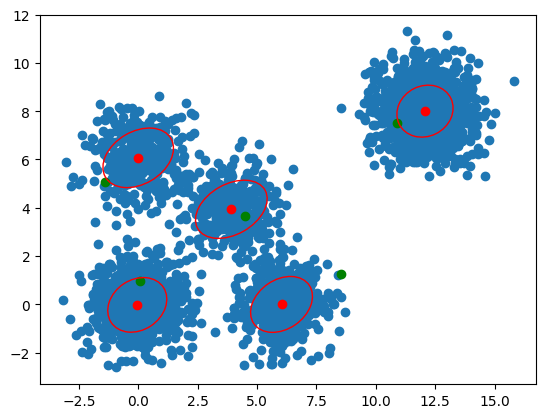

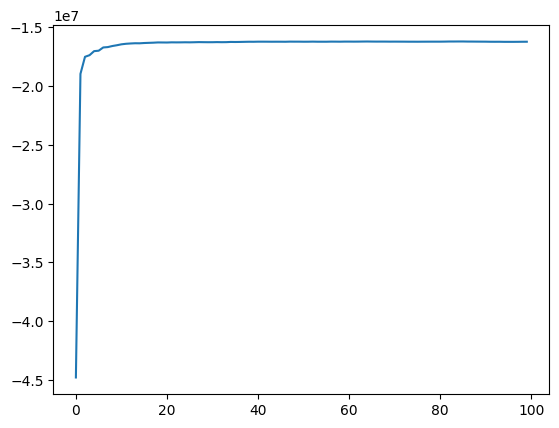

In [17]:
#batch 150 - 100 it
test_hmmbatchsgd(maxit=100, epsilon=epsilon, batch_size=150)

In [7]:
#in case we want to see the elbo

# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchsgd as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *

#make test_hmmbatchsgd return the elbo

#elbo=test_hmmbatchsgd()

#plt.plot(elbo)

#elbo

## Runtime comparison: sgd vs all observations

[9.99116713 2.04391164]
Hamming Distance =  0.433


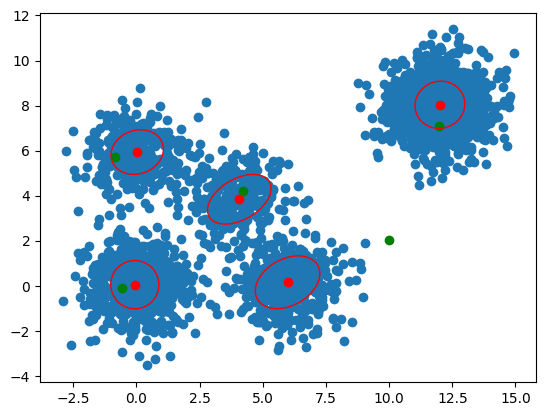

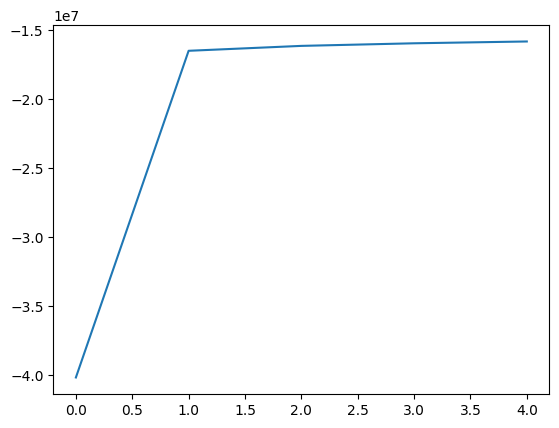

True
terminated early - convergence, 
 elbo : -15611374.843028631 
 lower bound : -15611374.843028631
allclose  = True, diff : 0.0
[-0.78165844  5.58490609]
Hamming Distance =  0.3393333333333333


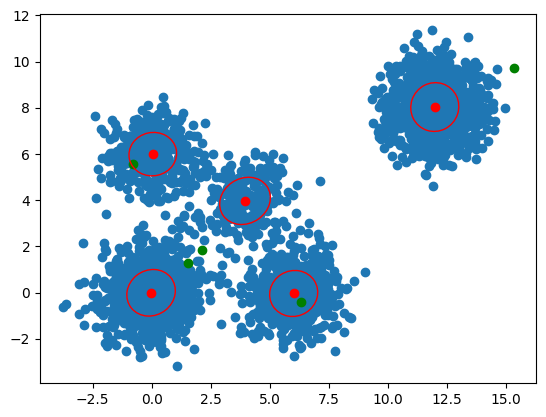

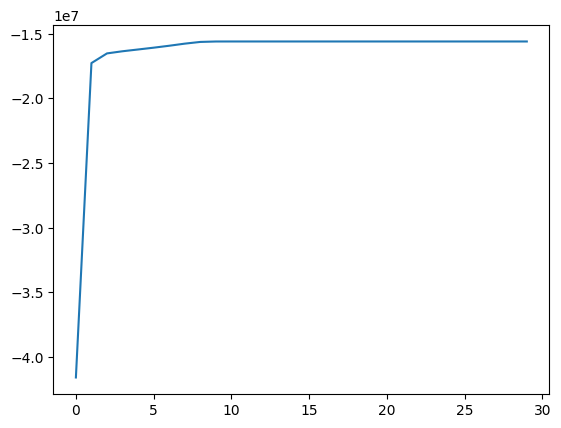

test_hmmbatchsgd() took 0.64 seconds to run
test_hmmbatchcd() took 2.23 seconds to run


In [8]:
#15 maxit 150 batch
from test_hmmbatchcd import *
from test_hmmbatchsgd import *
import time
epsilon = 10**(-7)
# time the execution of test_hmmbatchsgd()
start_time = time.time()
test_hmmbatchsgd(maxit=5, epsilon=epsilon, batch_size=256)
end_time = time.time()
elapsed_time_sgd = end_time - start_time

# time the execution of test_hmmbatchcd()
start_time = time.time()
test_hmmbatchcd()
end_time = time.time()
elapsed_time_cd = end_time - start_time

print("test_hmmbatchsgd() took {:.2f} seconds to run".format(elapsed_time_sgd))

print("test_hmmbatchcd() took {:.2f} seconds to run".format(elapsed_time_cd))

## Zoomed ELBO for SVI

In [5]:
#generate data

import numpy as np
from pybasicbayes import distributions as dist
from pybasicbayes.distributions import Gaussian
import matplotlib.pyplot as plt
from generate_data import *
from sklearn.cluster import KMeans


centers = np.array([np.array([0,0]),np.array([6,0]),np.array([4,4]),np.array([0,6]),np.array([12,8])])
# centers = [np.array([0,0]),np.array([6,6])]
# centers = [np.array([0,0,0]),np.array([6,0,6]),np.array([4,4,4])]

K = 5           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 0.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0.89,0.01,0.01,0.05,0.04],
    [0.05,0.8,0.05,0.05,0.05],
    [0.05,0.1,0.7,0.05,0.1],
    [0.1,0.1,0.05,0.7,0.05],
    [0.025,0.025,0.025,0.025,0.9]
    ])
# T = np.array([[0.8,0.2],[0.3,0.7]])

N = 3500

emit = make_emissions(centers , kappa_0, nu_0)


seq, ind = generate_states(T,N)

obs = generate_data(emit,ind)


#####

kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=42)
kmeans.fit(obs)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4


# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?
print(prior_emit[0].mu_mf)
# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state

In [15]:
#SVI

#code from test_batchsgd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchsgd as SGD_HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *

from pybasicbayes import distributions as dist
from generate_data import *

from sklearn.cluster import KMeans

maxit = 500
batch_size = 128
epsilon = 10**(-8)

# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state
hmm_sgd = SGD_HMM.VBHMM(obs, prior_init, prior_tran, prior_emit, maxit=maxit, epsilon=epsilon, batch_size=batch_size)  
hmm_sgd.infer() # do inference 
sts_true = seq # true states 
# hamming distance
print(prior_emit[0].mu_mf)
print('Hamming Distance = ', hmm_sgd.hamming_dist(hmm_sgd.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
#a = util.plot_emissions(obs, prior_emit, hmm_sgd.var_emit)
#plt.show()

[13.34177898  8.81697766]
Hamming Distance =  0.3606666666666667


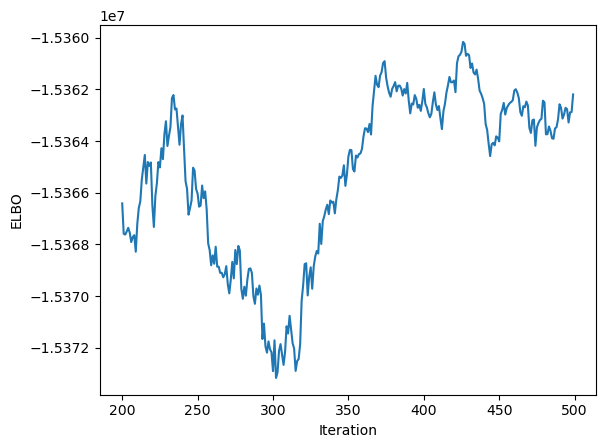

In [17]:
# plot elbo over iterations, zoom with
plt.xlabel('Iteration')
plt.ylabel('ELBO')

plt.plot(np.arange(200,500),hmm_sgd.elbo_vec[200:500])
plt.show()

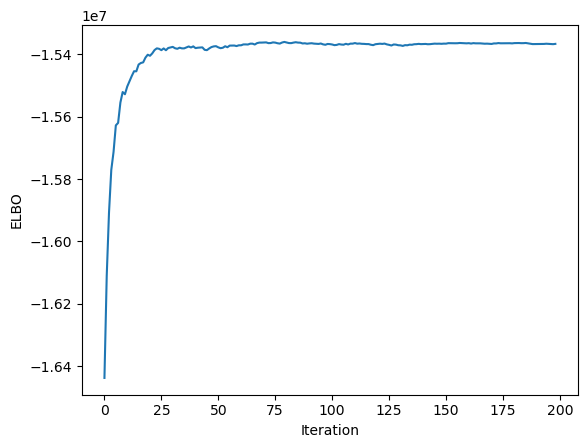

In [19]:
# plot elbo over iterations, zoom with
plt.xlabel('Iteration')
plt.ylabel('ELBO')

plt.plot(hmm_sgd.elbo_vec[1:200])
plt.show()

## hmm distance vs batch_size

In [ ]:
'''
for i, emit in enumerate(prior_emit):
    for item in emit.hypparams:
        distance = np.linalg.norm(prior_emit[i].hypparams.get(item) - hmm_sgd.var_emit[i].hypparams.get(item))
        print(distance)
'''

In [28]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *
import hmmbatchsgd as SGD_HMM
import time

start_time = time.time()

maxit = 15
n_reps = 200

batch_sizes = list(reversed(list(range(1, 300, 2))))
hmm_distances = []

#loop for different batch sizes
for j, batch_size in enumerate(batch_sizes):
    
    distance = 0
    
    for i in range(n_reps):
    
        hmm_sgd = SGD_HMM.VBHMM(obs, prior_init, prior_tran, prior_emit, maxit=maxit, epsilon=epsilon, batch_size=batch_size)  
        hmm_sgd.infer()
        
        distance += hmm_sgd.hamming_dist(hmm_sgd.var_x, sts_true)[0]
        
        #distance between prior_emit, hmm_sgd.var_emit
        
        if i % 16 == 0:
            print(" ", round(i*100/n_reps, 2), "%")

    distance = distance/n_reps
    hmm_distances.append(distance)
    
    print("Size: ", batch_size, "// Distance: ", distance)
    
    round_time = time.time() - start_time
    
    print("Runtime: ", round_time, " seconds")
    print("ETA: ", round(round_time*((len(batch_sizes)/(j+1)) -1), 1), " seconds"   )

end_time = time.time()
elapsed_time_sgd = end_time - start_time

print(n_reps,elapsed_time_sgd)

  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  299 // Distance:  0.3686350000000002
Runtime:  308.32907724380493  seconds
ETA:  46249.4  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  297 // Distance:  0.3602775
Runtime:  618.9338252544403  seconds
ETA:  46420.0  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  295 // Distance:  0.36709750000000013
Runtime:  933.0240602493286  seconds
ETA:  46651.2  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  293 // Distance:  0.3623850000000003
Runtime:  1247.09880900383  seconds
ETA:  46766.2  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  291 // Dis

  88.0 %
  96.0 %
Size:  225 // Distance:  0.3633258333333334
Runtime:  11929.525334358215  seconds
ETA:  47090.2  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  223 // Distance:  0.3665649999999999
Runtime:  12243.130778074265  seconds
ETA:  47089.0  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  221 // Distance:  0.36829083333333357
Runtime:  12556.1891644001  seconds
ETA:  47085.7  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  219 // Distance:  0.36725166666666675
Runtime:  12870.022592544556  seconds
ETA:  47085.4  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  217 // Distance:  0.36687166666666654
Runtime:  13184.131922245026  seconds
ETA:  47086.2  seco

  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  149 // Distance:  0.3693975000000001
Runtime:  23865.075147628784  seconds
ETA:  47102.1  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  147 // Distance:  0.3751025
Runtime:  24178.970372915268  seconds
ETA:  47101.9  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  145 // Distance:  0.36973916666666684
Runtime:  24492.864619255066  seconds
ETA:  47101.7  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  143 // Distance:  0.3680308333333333
Runtime:  24806.34318447113  seconds
ETA:  47100.7  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  141 // 

  80.0 %
  88.0 %
  96.0 %
Size:  75 // Distance:  0.38240916666666697
Runtime:  35483.060291051865  seconds
ETA:  47101.4  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  73 // Distance:  0.3728966666666668
Runtime:  35796.89037847519  seconds
ETA:  47101.2  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  71 // Distance:  0.3795866666666666
Runtime:  36110.656633615494  seconds
ETA:  47100.9  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  69 // Distance:  0.38609500000000013
Runtime:  36424.37404060364  seconds
ETA:  47100.5  seconds
  0.0 %
  8.0 %
  16.0 %
  24.0 %
  32.0 %
  40.0 %
  48.0 %
  56.0 %
  64.0 %
  72.0 %
  80.0 %
  88.0 %
  96.0 %
Size:  67 // Distance:  0.3783474999999998
Runtime:  36738.597985744476  seconds
ETA:  47100.8  s

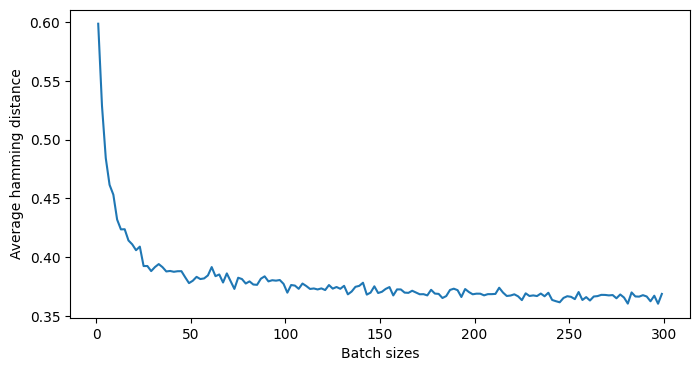

In [34]:
plt.figure(figsize=(8, 4))

#plt.yscale('log')  

plt.plot(batch_sizes, hmm_distances, '-') #'o-'
plt.xlabel('Batch sizes')
plt.ylabel('Average hamming distance')

plt.show()

## Plot comparisons  MCMC, VI full dataset, good/bad SVI 

In [ ]:
# add distribution plot comparison with 
#  MCMC, VI full dataset, good approx SVI with enough batch_size, bad approx SVI with small batch_size

# add 1 or 2 plots of zoomed elbo

# add plot of hmm distance vs batch_size


In [3]:
#generate data

import numpy as np
from pybasicbayes import distributions as dist
from pybasicbayes.distributions import Gaussian
import matplotlib.pyplot as plt
from generate_data import *

centers = np.array([np.array([0,0]),np.array([6,0]),np.array([4,4]),np.array([0,6]),np.array([12,8])])
# centers = [np.array([0,0]),np.array([6,6])]
# centers = [np.array([0,0,0]),np.array([6,0,6]),np.array([4,4,4])]

K = 5           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 0.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0.89,0.01,0.01,0.05,0.04],
    [0.05,0.8,0.05,0.05,0.05],
    [0.05,0.1,0.7,0.05,0.1],
    [0.1,0.1,0.05,0.7,0.05],
    [0.025,0.025,0.025,0.025,0.9]
    ])
# T = np.array([[0.8,0.2],[0.3,0.7]])

N = 3000

emit = make_emissions(centers , kappa_0, nu_0)


seq, ind = generate_states(T,N)

obs = generate_data(emit,ind)


[12.74154906  8.92325714]
True
terminated early - convergence, 
 elbo : -15403178.80525427 
 lower bound : -15403178.80525427
allclose  = True, diff : 0.0
[12.74154906  8.92325714]
Hamming Distance =  0.37166666666666665


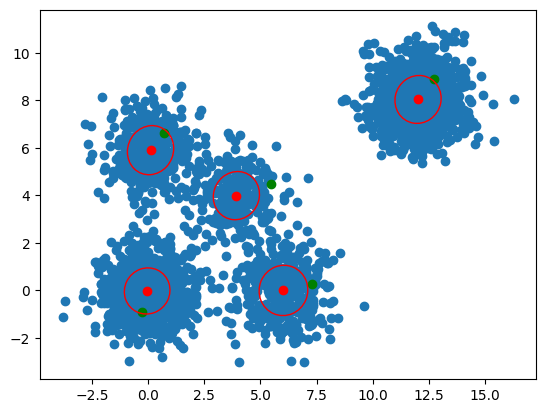

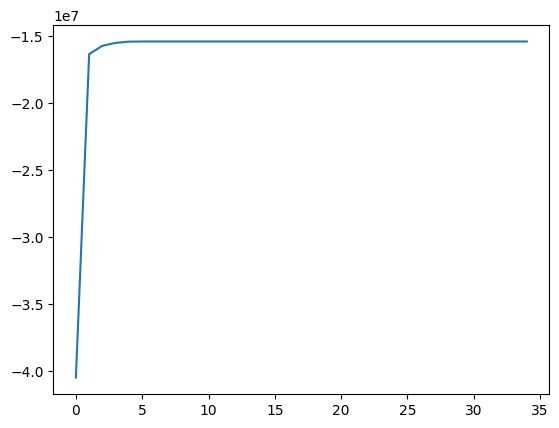

In [4]:
#VI

# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchcd as HMM
import seaborn as sns
from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *
from sklearn.cluster import KMeans


kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=42)
kmeans.fit(obs)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4


# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?
print(prior_emit[0].mu_mf)
# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state
hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit,maxit=1000, epsilon=10**(-12))  
hmm.infer() # do inference 
sts_true = seq # true states 
# hamming distance
print(prior_emit[0].mu_mf)
print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()


[12.74154906  8.92325714]
Hamming Distance =  0.37166666666666665


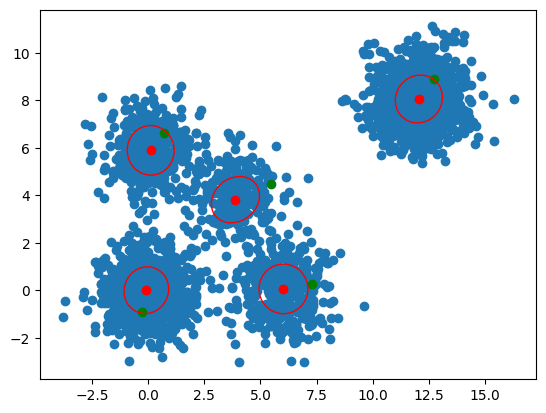

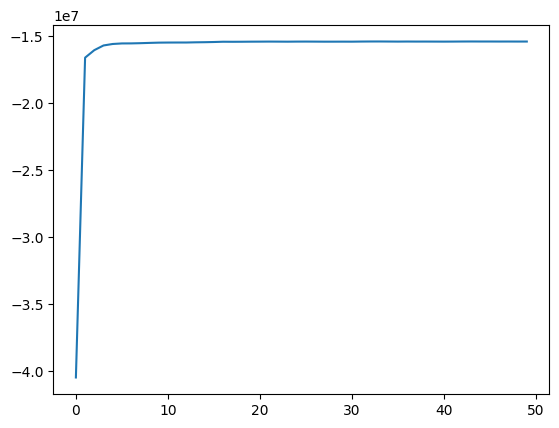

In [5]:
#SVI

#code from test_batchsgd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchsgd as SGD_HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *

from pybasicbayes import distributions as dist
from generate_data import *

from sklearn.cluster import KMeans

maxit = 50
batch_size = 256
epsilon = 10**(-8)

# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state
hmm_sgd = SGD_HMM.VBHMM(obs, prior_init, prior_tran, prior_emit, maxit=maxit, epsilon=epsilon, batch_size=batch_size)  
hmm_sgd.infer() # do inference 
sts_true = seq # true states 
# hamming distance
print(prior_emit[0].mu_mf)
print('Hamming Distance = ', hmm_sgd.hamming_dist(hmm_sgd.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs, prior_emit, hmm_sgd.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm_sgd.elbo_vec)
plt.show()

In [19]:
#MCMC
import time
import stan
import numpy as np
import nest_asyncio
nest_asyncio.apply()

dat = [tuple(i) for  i in obs]
data = {'y':dat , "N": N, "D":D, "K":K, 'mu_0':np.array([0,0]) , 'kappa_0':kappa_0, 'nu_0':nu_0,'Psi_0':sigma_0,'alpha_0':np.ones((K,K))} #specify dirichlet prior [1,1,1,...] on transitions

# read code from .stan file 
with open('BenJackCode/MvNormEmis_HMM.stan') as f:
    stan_code = f.read()

# build stan model
jack_model = stan.build(stan_code,data)

N_MCMC = 2000 

# start sampling
start_time = time.time()

fit = jack_model.sample(num_chains = 2, num_samples = 1000+N_MCMC, num_warmup = 2000 )

end_time = time.time()


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ms430wpv/model_7dyjzdpz.stan', line 10, column 50: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/tmp/httpstan_ms430wpv/model_7dyjzdpz.stan', line 10, column 62: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/tmp/httpstan_ms430wpv/model_7dyjzdpz.stan', line 11, column 26: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/t

Sampling:  74% (7400/10000)
Sampling:  75% (7500/10000)
Sampling:  76% (7600/10000)
Sampling:  77% (7700/10000)
Sampling:  78% (7800/10000)
Sampling:  79% (7900/10000)
Sampling:  80% (8000/10000)
Sampling:  81% (8100/10000)
Sampling:  82% (8200/10000)
Sampling:  83% (8300/10000)
Sampling:  84% (8400/10000)
Sampling:  85% (8500/10000)
Sampling:  86% (8600/10000)
Sampling:  87% (8700/10000)
Sampling:  88% (8800/10000)
Sampling:  89% (8900/10000)
Sampling:  90% (9000/10000)
Sampling:  91% (9100/10000)
Sampling:  92% (9200/10000)
Sampling:  93% (9300/10000)
Sampling:  94% (9400/10000)
Sampling:  95% (9500/10000)
Sampling:  96% (9600/10000)
Sampling:  97% (9700/10000)
Sampling:  98% (9800/10000)
Sampling:  99% (9900/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.016813 seconds
  1000 transitions using 10 leapfrog steps per transition would take 168.13 seconds.
  Adjust your expectations accordingly!
  I

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


In [15]:
elapsed_time_mcmc = end_time - start_time
elapsed_time_mcmc

864.7815315723419

In [16]:
#plot preparation

# for every state extract parameters into a dict 
from scipy.stats import invwishart,t,beta

MCMC_mus = {}
MCMC_sig = {}
MCMC_gamm = {}

true_map_MCMC = [np.argmin(np.sqrt(np.sum((np.mean(fit['mu'][i].T, axis =0)-centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(fit['mu'].shape[0]):
    MCMC_mus[str(true_map_MCMC[i])] = fit['mu'][i].T
    MCMC_sig[str(true_map_MCMC[i])] = fit['Sigma'][i].T
    MCMC_gamm[str(true_map_MCMC[i])] = {}
    for j in range(fit['mu'].shape[0]):
        MCMC_gamm[str(true_map_MCMC[i])][str(true_map_MCMC[j])] = fit['gamma'][i].T[:,j]



VI_mus = {}
VI_sig = {}
VI_kapp = {}
VI_nu = {}
VI_alphas = {}

true_map_VI = [np.argmin(np.sqrt(np.sum((hmm.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(0,len(hmm.var_emit)):
    VI_mus[str(true_map_VI[i])] = hmm.var_emit[i].mu_mf
    VI_sig[str(true_map_VI[i])] = hmm.var_emit[i].sigma_mf
    VI_kapp[str(true_map_VI[i])] = hmm.var_emit[i].kappa_mf
    VI_nu[str(true_map_VI[i])] = hmm.var_emit[i].nu_mf
    VI_alphas[str(true_map_VI[i])] = {}
    for j in range(0,len(hmm.var_emit)):
        VI_alphas[str(true_map_VI[i])][str(true_map_VI[j])] = hmm.var_tran[i][j]
        
SVI_mus = {}
SVI_sig = {}
SVI_kapp = {}
SVI_nu = {}
SVI_alphas = {}

true_map_SVI = [np.argmin(np.sqrt(np.sum((hmm_sgd.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(0,len(hmm_sgd.var_emit)):
    SVI_mus[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].mu_mf
    SVI_sig[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].sigma_mf
    SVI_kapp[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].kappa_mf
    SVI_nu[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].nu_mf
    SVI_alphas[str(true_map_SVI[i])] = {}
    for j in range(0,len(hmm_sgd.var_emit)):
        SVI_alphas[str(true_map_SVI[i])][str(true_map_SVI[j])] = hmm_sgd.var_tran[i][j]

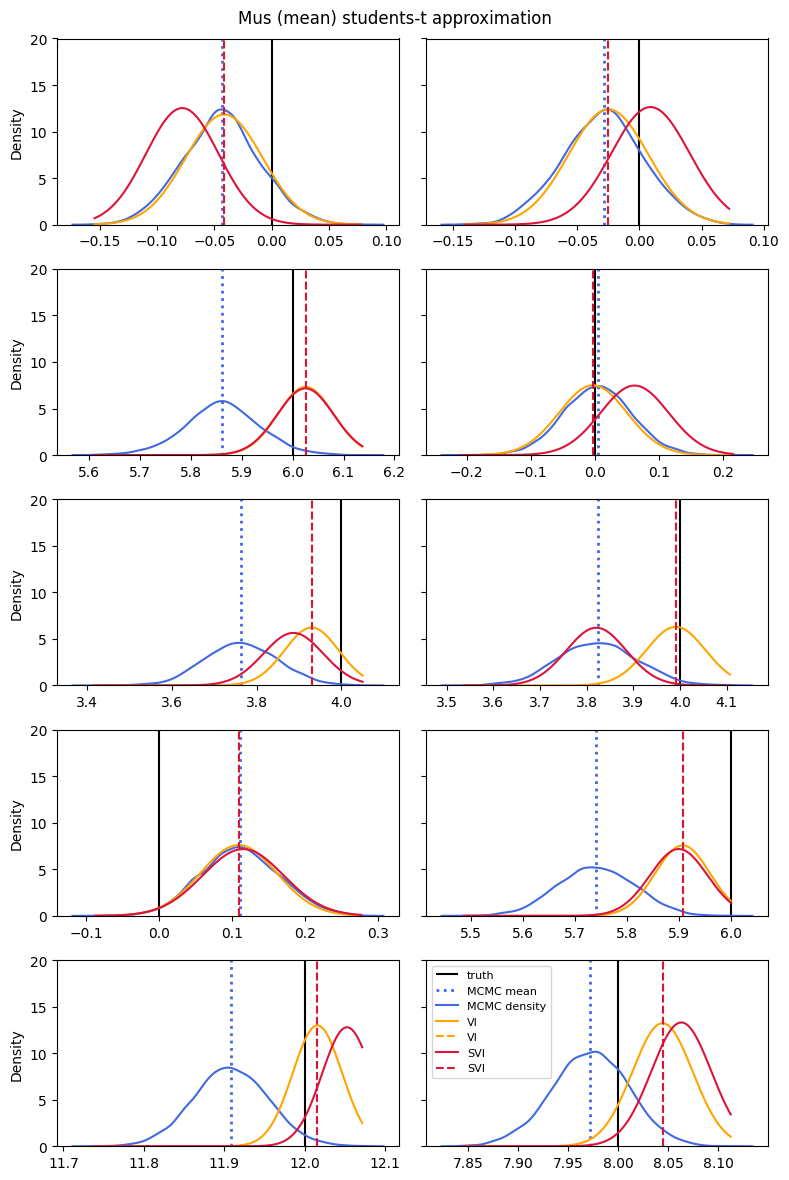

In [17]:
#mus
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)

for k in range(K):
    for d in range(D):
        ax = axs[k,d]

        ax.vlines(centers[k][d],0,20,color = 'black',label='truth')

        ax.vlines(np.mean(MCMC_mus[str(k+1)].T[d]),0,20 ,linestyles='dotted',linewidth = 2, label='MCMC mean',color = 'royalblue')
        sns.kdeplot(MCMC_mus[str(k+1)].T[d],label='MCMC density',ax=ax,color = 'royalblue')

        x = np.linspace(min(MCMC_mus[str(k+1)].T[d]+0.00001),max(MCMC_mus[str(k+1)].T[d]),500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        ax.plot(x, t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd)),label = 'VI',color = 'orange')
        ax.vlines(VI_mus[str(k+1)][d],0,20,color = 'orange',label='VI',linestyles='dashed')
        
        #SVI
        scale_kd = np.diag(SVI_sig[str(k+1)])[d] / (SVI_kapp[str(k+1)]*( SVI_nu[str(k+1)] + D - 1 ))
        
        ax.plot(x, t.pdf(x, df = SVI_nu[str(k+1)], loc=SVI_mus[str(k+1)][d], scale=np.sqrt(scale_kd)),label = 'SVI',color = 'crimson')
        ax.vlines(VI_mus[str(k+1)][d],0,20,color = 'crimson',label='SVI',linestyles='dashed')
        
        plt.ylim((0,20))
plt.suptitle('Mus (mean) students-t approximation')
legend = plt.legend(fontsize = 8)
plt.tight_layout()

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)


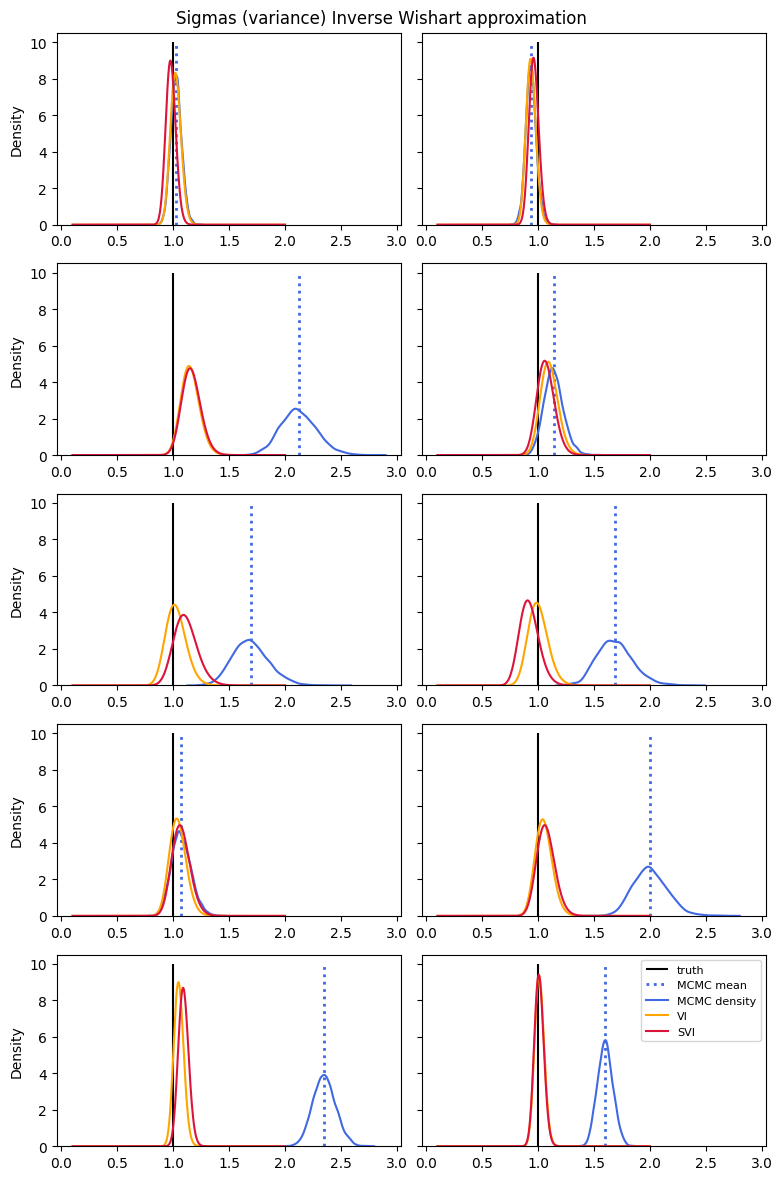

In [18]:
#sigmas
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        ax.vlines(1,0,10,color = 'black',label='truth')

        ax.vlines(np.mean(MCMC_sig[str(k+1)][:][:,d,d]),0,10,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')

        sns.kdeplot(MCMC_sig[str(k+1)][:][:,d,d],label='MCMC density',ax=ax,color='royalblue')

        x = np.linspace(0.1,2,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI',color = 'orange')
        
        iw = invwishart.pdf(x, df=SVI_kapp[str(k+1)], scale = np.diag(SVI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'SVI',color = 'crimson')
        
        ax.sharex(axs[:][d][0])

plt.suptitle('Sigmas (variance) Inverse Wishart approximation')
plt.legend(fontsize = 8)
plt.tight_layout()

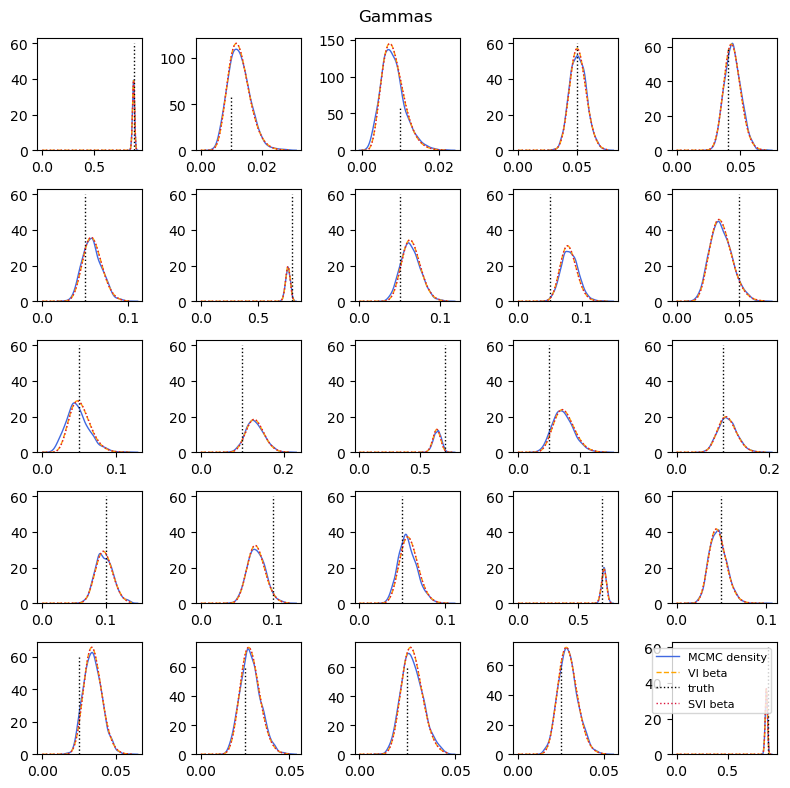

In [49]:
#gammas
K=5
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        ax = axs[k,j]
        sns.kdeplot(MCMC_gamm[str(k+1)][str(j+1)],label='MCMC density',ax=ax,linewidth=1.0,color= 'royalblue')
        x = np.linspace(0,max(MCMC_gamm[str(k+1)][str(j+1)]),500)
        dist = beta.pdf(x,VI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-VI_alphas[str(k+1)][str(j+1)])
        ax.plot(x, dist,label = 'VI beta',color = 'orange',linewidth=1.0,linestyle = 'dashed')
        ax.vlines(T[k][j],0,60,color = 'black',label='truth',linewidth=1.0,linestyle = 'dotted')
        
        #SVI
        dist = beta.pdf(x,SVI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-SVI_alphas[str(k+1)][str(j+1)])
        ax.plot(x, dist,label = 'SVI beta',color = 'crimson',linewidth=1.0,linestyle = 'dotted')
        
        # ax.set_xlim(0,1)
        ax.set(ylabel=None)


plt.suptitle('Gammas')
plt.legend(fontsize = 8)
plt.tight_layout()